# Проект 3. О вкусной и здоровой пище

в этом модуле вы будете работать с датасетом, содержащим сведения о 40 000 ресторанах Европы, а модель, которую вы будете обучать, должна будет предсказывать рейтинг ресторана по данным сайта TripAdvisor на основе имеющихся в датасете данных.

Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:

1. Restaurant_id — идентификационный номер ресторана / сети ресторанов;

2. City — город, в котором находится ресторан;

3. Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

4. Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;

5. Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);

6. Price Range — диапазон цен в ресторане;

7. Number of Reviews — количество отзывов о ресторане;

8. Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;

9. URL_TA — URL страницы ресторана на TripAdvosor;

10. ID_TA — идентификатор ресторана в базе данных TripAdvisor.

## Подключение модулей и чтение файла

In [1]:
# импорт необходимых пакетов
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import re
from datetime import datetime, timedelta
from collections import Counter

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

main_task = pd.read_csv('main_task.csv')  # чтение данных из CSV файла

## Просмотр данных и получение информации о них

In [2]:
main_task.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


Для удобства работы переименуем столбцы, имеющие в названии несколько слов, так, чтобы в них отсутствовали проблы:

In [3]:
main_task = main_task.rename(columns={
    'Cuisine Style': 'Cuisine_Style',
    'Price Range': 'Price_Range',
    'Number of Reviews': 'Number_of_Reviews'
})
main_task.sample()

,Restaurant_id,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA
20745,id_1511,Amsterdam,"['French', 'Mediterranean', 'Bar', 'European',...",1514.0,3.5,$$ - $$$,234.0,"[[""Cocktail o'clock"", 'Better than reviews led...",/Restaurant_Review-g188590-d8369026-Reviews-Ca...,d8369026


In [4]:
main_task.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine_Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price_Range        26114 non-null  object 
 6   Number_of_Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
main_task.describe()

,Ranking,Rating,Number_of_Reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


## Пропуски

Тепловая карта пропущенных значений

<AxesSubplot:>

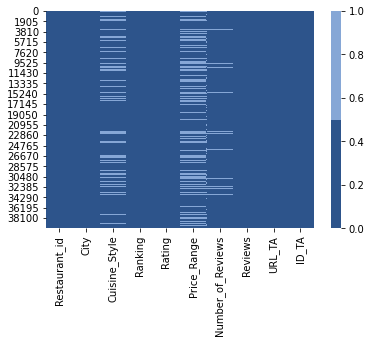

In [6]:
cols = main_task.columns[:]  # все колонки
# определяем цвета
# голубой - пропущенные данные, синий - не пропущенные
colours = ['#2d548b', '#86a7d6']
sns.heatmap(main_task[cols].isnull(), cmap=sns.color_palette(colours))

Приведенная выше карта демонстрирует паттерн пропущенных значений для всех признаков набора. По горизонтальной оси расположены признаки, по вертикальной – количество записей/строк. Голубой цвет соответствует пропускам данных.

## Процентный список пропущенных данных

Составим список долей отсутствующих значений для каждого признака:

In [7]:
for col in main_task.columns:
    pct_missing = np.mean(main_task[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

Restaurant_id - 0.0%
City - 0.0%
Cuisine_Style - 23.0%
Ranking - 0.0%
Rating - 0.0%
Price_Range - 35.0%
Number_of_Reviews - 6.0%
Reviews - 0.0%
URL_TA - 0.0%
ID_TA - 0.0%


#### Вывод: по трём признакам имеются пропуски: Cuisine Style (23%), Price Range (35%) и Number of Reviews (6%).

## Удаление дублей

In [8]:
# сохраним первоначальное количество строкв в переменную length:
length = len(main_task)

# удаление совпадений по всем признакам:
main_task.drop_duplicates(subset=main_task.columns[:-1], inplace=True)

print('Количество удалённых строк с совпадением по всем признакам:',
      length - len(main_task))

Количество удалённых строк с совпадением по всем признакам: 0


In [9]:
# проверка на наличие одинаковых отзывов и их просмотр
# (нулевая строка — это количество пустых значений):
main_task['Reviews'].value_counts()[1:6]

[['Good Lebanese food', 'Decent place'], ['07/19/2017', '03/17/2017']]                     2
[['Happened to drop in', 'Right for a quick bite'], ['11/30/2016', '06/20/2015']]          2
[['Great Food! Wide Variety.', 'Dinner'], ['11/26/2017', '05/23/2017']]                    2
[['Very good all around', 'Our first Madrid restaurant'], ['11/20/2017', '10/11/2017']]    2
[['The real codido madrileño'], ['03/31/2017']]                                            2
Name: Reviews, dtype: int64

In [10]:
# удаление строк с совпадением по идентификатору ресторана в базе данных TripAdvisor и по отзывам:
main_task.drop_duplicates(subset=['ID_TA', 'Reviews'], inplace=True)

print('Количество удалённых строк с совпадением по столбцам «ID_TA» и «Reviews»:',
      length - len(main_task))

Количество удалённых строк с совпадением по столбцам «ID_TA» и «Reviews»: 20


Вывод: полностью одинаковые записи отсутствуют. Удалено 20 строк с совпадением по столбцам «ID_TA» и «Reviews», в которых хранятся идентификатор ресторана в базе данных TripAdvisor и данные о двух отзывах, отображающихся на сайте ресторана, соответственно.

Наличие нескольких записей c одинаковыми отзывами для одного ресторана выглядит неправдопадобно, поэтому повторяющиеся строки исключены из анализа.

### Restaurant_id 

Преобразование значений столбца «Restaurant_id» в числовой тип данных подразумевая, что наименьшее значение «Restaurant_id» соответсвует раннему появлению:

In [11]:
# оставим лишь числовое значение:
main_task.Restaurant_id = main_task.Restaurant_id.str.replace('id_', '')
# преобразуем строки в целочисленный тип данных:
main_task.Restaurant_id = [int(x) for x in main_task.Restaurant_id]

Создание нового признака «Number_of_Restaurants», в котором будет храниться информация о количестве ресторанов на один «Restaurant_id»:

In [12]:
# создание DataFrame со столбцом «Restaurant_id»:
df = pd.DataFrame(main_task, columns=['Restaurant_id'])

# создание DataFrame «df_new», в котором хранится информация о идентификационном номере ресторана / сети ресторанов
# и количестве ресторанов, приходящемся на один такой идентификационный номер:
df_new = df['Restaurant_id'].value_counts().to_frame().reset_index().rename(
    columns={'index': 'Restaurant_id', 'Restaurant_id': 'Number_of_Restaurants'})

# добавление DataFrame «df_new» к основному DataFrame «main_task»:
main_task = pd.merge(main_task, df_new, on='Restaurant_id')

### ID_TA

Преобразование значений столбца «ID_TA» в числовой тип данных с той логикой, что наименьшее значение в этом столбце соответсвует раннему появлению в базе TripAdvisor:

In [13]:
main_task.ID_TA = main_task.ID_TA.str.replace('d', '')
# преобразуем строки в целочисленный тип данных:
main_task.ID_TA = [int(x) for x in main_task.ID_TA]

### Price_Range 

Преобразование значений столбца «Price_Range» в числовой тип данных:

In [14]:
# просмотр значений в столбце «Price_Range»:
main_task['Price_Range'].value_counts()

$$ - $$$    18402
$            6276
$$$$         1423
Name: Price_Range, dtype: int64

In [15]:
# создание словаря для назначения числового значения соответствующей записи:
price_range = {
    '$': 1,
    '$$ - $$$': 2,
    '$$$$': 3
}
# замена в столбце «Price_Range» строк на числа:
main_task['Price_Range'] = main_task['Price_Range'].replace(
    to_replace=price_range)

Заполнение пропусков в столбце «Price_Range» медианой:

In [16]:
# вычисление медианы:
median_price_range = main_task['Price_Range'].median()
# замена:
main_task['Price_Range'] = main_task['Price_Range'].fillna(median_price_range)

In [17]:
print('Количество городов, представленных в наборе данных:',
      len(main_task.City.unique()))

Количество городов, представленных в наборе данных: 31


In [18]:
print('Количество ресторанов и сетей ресторанов, представленных в наборе данных:',
      len(main_task.Restaurant_id.unique()))

Количество ресторанов и сетей ресторанов, представленных в наборе данных: 11907


### Cuisine_Style

Если в данных отсутствует информация о типах кухонь, то считается, что в этом ресторане предлагается только один тип кухни.

In [19]:
# Счётчик видов кухонь, встречающихся в данных:
cuisine_styles = Counter()
for i in main_task['Cuisine_Style'].dropna():
    i = i[1:-1].replace("'", "").split(', ')
    i = [style for style in i if len(i) > 0]
    cuisine_styles.update(i)

print('В наборе данных представлено', len(cuisine_styles), 'кухонь.')
print('В наибольшем количестве ресторанов представлена кухня:',
      cuisine_styles.most_common()[0][0])

В наборе данных представлено 125 кухонь.
В наибольшем количестве ресторанов представлена кухня: Vegetarian Friendly


In [20]:
# Преобразование строковых значений столбца «Cuisine_Style» в список и заполнение пропусков словом «Local» - местная кухня:
main_task['Cuisine_Style'] = main_task['Cuisine_Style'].apply(
    lambda x: ['Local'] if pd.isnull(x) else x[1:-1].split(','))

Добавление нового признака «Cuisines_Count» (количество кухонь в ресторане):

In [21]:
main_task['Cuisines_Count'] = main_task['Cuisine_Style'].apply(
    lambda x: len(x))

print('Среднее количество кухонь на один ресторан:',
      round(main_task['Cuisines_Count'].mean(), 1))

Среднее количество кухонь на один ресторан: 2.6


### Dummy variables

In [22]:
def get_cuisines_list(main_task):
    cuisines = set()
    for cuisine in main_task['Cuisine_Style'].dropna().values:
        cuisines.update(cuisine)
    return cuisines


list_of_cuisines = get_cuisines_list(main_task)

In [23]:
def count_cuisines_prevalence(data, kit):
    cuisines_prevalence = {}
    for cuisine in kit:
        cuisines_prevalence[cuisine] = 0

    for cuisine in data['Cuisine_Style'].dropna().values:
        for style in cuisine:
            cuisines_prevalence[style] = cuisines_prevalence[style]+1
    return cuisines_prevalence


prevalence_cuisine = count_cuisines_prevalence(main_task, list_of_cuisines)

In [24]:
# выделим две группы кухонь те которые представлены хотя бы в 10% ресторанов и остальные
top_cuisines = []
low_cuisines = []
for cuisine in prevalence_cuisine:
    if prevalence_cuisine[cuisine] > len(main_task) * .1:
        top_cuisines.append(cuisine)
    else:
        low_cuisines.append(cuisine)

In [25]:
# создадим отдельные признаки для кухонь представленых хотя бы в 10%
def top_cuisine_present(x):
    return 1 if cuisine in x else 0

for cuisine in top_cuisines:
    dummy = main_task['Cuisine_Style'].apply(top_cuisine_present)
    main_task['Cuisine_' + cuisine] = dummy

# для остальных добавим признак Cuisine_Other
def is_low_cuisine_present(x):
    for cuisine in low_cuisines:
        if cuisine in x:
            return 1
    return 0

main_task['Cuisine_Other'] = main_task['Cuisine_Style'].apply(is_low_cuisine_present)

### Добавление нового признака «Number_of_City» (количество ресторанов в городе):

In [26]:
# создание DataFrame со столбцом «City»:
df = pd.DataFrame(main_task, columns=['City'])

# создание DataFrame «df_new», в котором хранится информация о городе
# и количестве ресторанов, приходящемся на один город (в этой базе данных):
df_new = df['City'].value_counts().to_frame().reset_index().rename(
    columns={'index': 'City', 'City': 'Number_of_City'})

# добавление DataFrame «df_new» к основному DataFrame «main_task»:
main_task = pd.merge(main_task, df_new, on='City')

<AxesSubplot:>

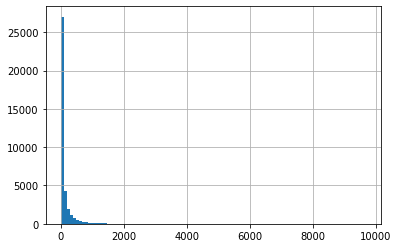

In [27]:
main_task['Number_of_Reviews'].hist(bins=100)

### Вычленение дат последних отзывов

In [28]:
main_task['Date_of_Review'] = main_task['Reviews'].str.findall(
    '\d\d\S\d\d\S\d\d\d\d')

In [29]:
main_task['data_1'] = main_task['Date_of_Review'].apply(
    lambda x: pd.to_datetime(x[-1]) if len(x) >= 1 else np.NaN)
main_task['data_2'] = main_task['Date_of_Review'].apply(
    lambda x: (pd.to_datetime(x[0]) if len(x) > 1 else np.NaN))

main_task['data_1'] = main_task['data_1'].dt.date
main_task['data_2'] = main_task['data_2'].dt.date

print('Максимальное количество дней отделяющих даты публикации отзывов, размещённых на сайте ресторана:',
      (main_task['data_2']-main_task['data_1']).max())

main_task['Days_between_Reviews'] = (
    main_task['data_2']-main_task['data_1']).dt.days

main_task['data_1'] = main_task['data_1'].fillna(0)
main_task['data_2'] = main_task['data_2'].fillna(0)
main_task['Days_between_Reviews'] = main_task['Days_between_Reviews'].fillna(0)

Максимальное количество дней отделяющих даты публикации отзывов, размещённых на сайте ресторана: 3207 days 00:00:00


### Number_of_Reviews

In [30]:
# если в столбцах о дате нулевые значения, значит отзывов не было или был всего один отзыв:
def replacement(row):
    if row.data_1 == 0 and row.data_2 == 0:
        return 0
    elif row.data_1 != 0 and row.data_2 == 0:
        return 1
    else:
        return row.Number_of_Reviews


# поправка и заполнение пропущенных значений:
main_task['Number_of_Reviews'] = main_task.apply(
    lambda row: replacement(row), axis=1)

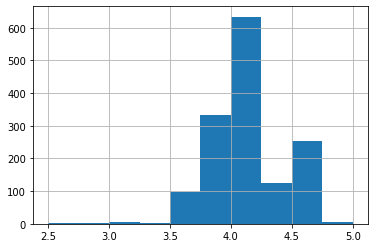

In [31]:
Rating_Reviews = main_task.groupby(['Number_of_Reviews']).Rating.mean().hist()

### Создание новых признаков «Multi_Rating» и «Weght_of_Rating»

In [32]:
# Создание признака «Multi_Rating»:
main_task['Multi_Rating'] = main_task['Ranking'] * \
    main_task['Rating']*main_task['Number_of_Reviews']

# Создание признака «Weght_of_Rating»:
main_task['Weght_of_Rating'] = main_task['Number_of_Reviews'] * \
    main_task['Rating']

### Проверка на нулевые значения

In [33]:
count_nan = len(main_task) - main_task.count()
print(count_nan)

Restaurant_id                     0
City                              0
Cuisine_Style                     0
Ranking                           0
Rating                            0
Price_Range                       0
Number_of_Reviews                 0
Reviews                           0
URL_TA                            0
ID_TA                             0
Number_of_Restaurants             0
Cuisines_Count                    0
Cuisine_ 'European'               0
Cuisine_ 'Vegetarian Friendly'    0
Cuisine_ 'Gluten Free Options'    0
Cuisine_ 'Mediterranean'          0
Cuisine_'Italian'                 0
Cuisine_Local                     0
Cuisine_ 'Vegan Options'          0
Cuisine_Other                     0
Number_of_City                    0
Date_of_Review                    0
data_1                            0
data_2                            0
Days_between_Reviews              0
Multi_Rating                      0
Weght_of_Rating                   0
dtype: int64


### Матрица корреляции

<AxesSubplot:>

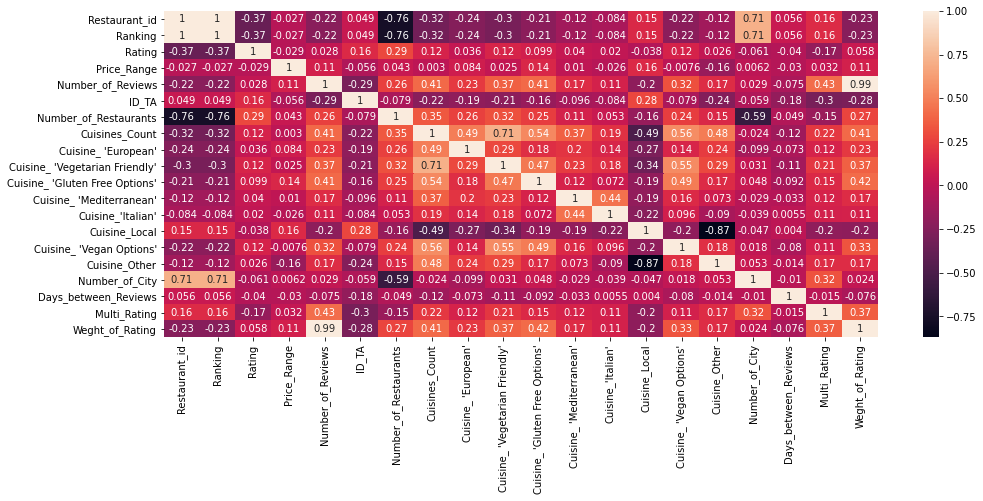

In [34]:
C = main_task.corr()
plt.figure(figsize=(16, 6))
sns.heatmap(data=C, annot=True)

## Нормализация данных

In [35]:
# Отбор числовых колонок
df_numeric = main_task.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['Restaurant_id' 'Ranking' 'Rating' 'Price_Range' 'Number_of_Reviews'
 'ID_TA' 'Number_of_Restaurants' 'Cuisines_Count' "Cuisine_ 'European'"
 "Cuisine_ 'Vegetarian Friendly'" "Cuisine_ 'Gluten Free Options'"
 "Cuisine_ 'Mediterranean'" "Cuisine_'Italian'" 'Cuisine_Local'
 "Cuisine_ 'Vegan Options'" 'Cuisine_Other' 'Number_of_City'
 'Days_between_Reviews' 'Multi_Rating' 'Weght_of_Rating']


In [36]:
from sklearn.preprocessing import StandardScaler

columns_for_scaling = ['Restaurant_id', 'Ranking',
                       'Price_Range', 'Number_of_Reviews',
                       'ID_TA', 'Number_of_Restaurants',
                       'Cuisines_Count', 'Number_of_City',
                       'Days_between_Reviews', 'Multi_Rating',
                       'Weght_of_Rating']

scaled_df = main_task[columns_for_scaling]
scaled_df.info()

scaler = StandardScaler()
scaled = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled)
scaled_df.columns = columns_for_scaling

for col in columns_for_scaling:
    main_task[col] = scaled_df[col]

main_task.sample(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39980 entries, 0 to 39979
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Restaurant_id          39980 non-null  int64  
 1   Ranking                39980 non-null  float64
 2   Price_Range            39980 non-null  float64
 3   Number_of_Reviews      39980 non-null  float64
 4   ID_TA                  39980 non-null  int64  
 5   Number_of_Restaurants  39980 non-null  int64  
 6   Cuisines_Count         39980 non-null  int64  
 7   Number_of_City         39980 non-null  int64  
 8   Days_between_Reviews   39980 non-null  float64
 9   Multi_Rating           39980 non-null  float64
 10  Weght_of_Rating        39980 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 3.7 MB


,Restaurant_id,City,Cuisine_Style,Ranking,Rating,Price_Range,Number_of_Reviews,Reviews,URL_TA,ID_TA,Number_of_Restaurants,Cuisines_Count,Cuisine_ 'European',Cuisine_ 'Vegetarian Friendly',Cuisine_ 'Gluten Free Options',Cuisine_ 'Mediterranean',Cuisine_'Italian',Cuisine_Local,Cuisine_ 'Vegan Options',Cuisine_Other,Number_of_City,Date_of_Review,data_1,data_2,Days_between_Reviews,Multi_Rating,Weght_of_Rating
26337,0.048437,Berlin,[Local],0.048121,4.0,0.287844,-0.335831,"[['Cheapest and yummiest Italian food', 'Great...",/Restaurant_Review-g187323-d5529357-Reviews-Pa...,-0.193375,-0.831288,-0.892708,0,0,0,0,0,1,0,0,-0.219732,"[10/31/2016, 10/29/2015]",2015-10-29,2016-10-31,1.358640,-0.259825,-0.328288
13722,-0.879619,Warsaw,['Vegetarian Friendly'],-0.879778,4.5,-2.083471,-0.315039,"[['Delicious and authentic', 'Superbe viet foo...",/Restaurant_Review-g274856-d11687457-Reviews-V...,1.370033,1.586814,-0.892708,0,0,0,0,0,0,0,1,-0.986568,"[09/13/2017, 05/30/2017]",2017-05-30,2017-09-13,0.078784,-0.403473,-0.298578
16546,0.254761,London,"['Japanese', 'Fast Food', 'Sushi', 'Asian',...",0.255968,4.0,-2.083471,0.329484,"[['Sweet chili chicken', 'Promises so much, de...",/Restaurant_Review-g186338-d2265446-Reviews-Wa...,-1.022010,-0.589477,1.308267,0,1,0,0,0,0,0,1,1.714543,"[01/03/2018, 11/25/2017]",2017-11-25,2018-01-03,-0.248508,2.100679,0.314443


### Проверка на нулевые значения

In [37]:
count_nan = len(main_task) - main_task.count()
print(count_nan)

Restaurant_id                     0
City                              0
Cuisine_Style                     0
Ranking                           0
Rating                            0
Price_Range                       0
Number_of_Reviews                 0
Reviews                           0
URL_TA                            0
ID_TA                             0
Number_of_Restaurants             0
Cuisines_Count                    0
Cuisine_ 'European'               0
Cuisine_ 'Vegetarian Friendly'    0
Cuisine_ 'Gluten Free Options'    0
Cuisine_ 'Mediterranean'          0
Cuisine_'Italian'                 0
Cuisine_Local                     0
Cuisine_ 'Vegan Options'          0
Cuisine_Other                     0
Number_of_City                    0
Date_of_Review                    0
data_1                            0
data_2                            0
Days_between_Reviews              0
Multi_Rating                      0
Weght_of_Rating                   0
dtype: int64


### Удаление столбцов, содержащих данные типа object

In [38]:
df_non_numeric = main_task.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values

for col in non_numeric_cols:
    main_task = main_task.drop([col], axis=1)

In [39]:
main_task.head()

,Restaurant_id,Ranking,Rating,Price_Range,Number_of_Reviews,ID_TA,Number_of_Restaurants,Cuisines_Count,Cuisine_ 'European',Cuisine_ 'Vegetarian Friendly',Cuisine_ 'Gluten Free Options',Cuisine_ 'Mediterranean',Cuisine_'Italian',Cuisine_Local,Cuisine_ 'Vegan Options',Cuisine_Other,Number_of_City,Days_between_Reviews,Multi_Rating,Weght_of_Rating
0,0.511251,0.510453,3.5,0.287844,0.277506,-1.111579,-0.831288,0.207780,0,0,0,0,0,0,0,1,1.252723,-0.238738,2.044825,0.183051
1,-0.576740,-0.577038,5.0,-2.083471,-0.391273,-0.123549,0.861384,-0.892708,0,0,0,0,0,0,0,1,1.252723,-0.439021,-0.426432,-0.381012
2,-0.058636,-0.059172,4.0,0.287844,-0.169502,-1.110612,-0.589477,0.758024,0,1,0,0,0,0,0,1,1.252723,2.804585,0.157042,-0.167605
3,-0.824869,-0.825053,4.5,0.287844,0.048804,-1.257573,1.828624,0.758024,0,1,0,0,0,0,1,1,1.252723,-0.185003,-0.199145,0.096852
4,-0.526845,-0.527166,5.0,2.659158,-0.304644,1.603659,0.619574,-0.342464,0,0,0,0,0,0,0,1,1.252723,-0.370632,-0.284974,-0.276401


# RandomForestRegression

## Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [40]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = main_task.drop(['Restaurant_id', 'Rating'], axis=1)
y = main_task['Rating']

In [41]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [42]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## Создание, обучение и тестирование модели

In [43]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

### Mean Absolute Error (MAE) - метрика, представляющая собой среднее абсолютное значение отклонения предсказанных значений от фактических:



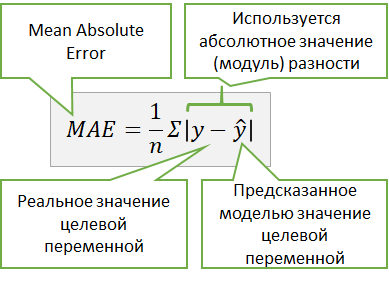

Иными словами, если у вас получился результат MAE = 0.5, то это значит, что модель при расчёте рейтинга ошибается в среднем на 0.5 баллов.

In [44]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

# MAE до очистки данных: 0.43

# MAE: 0.19330065032516253

MAE: 0.19453026513256627


In [45]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
  
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
  
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)